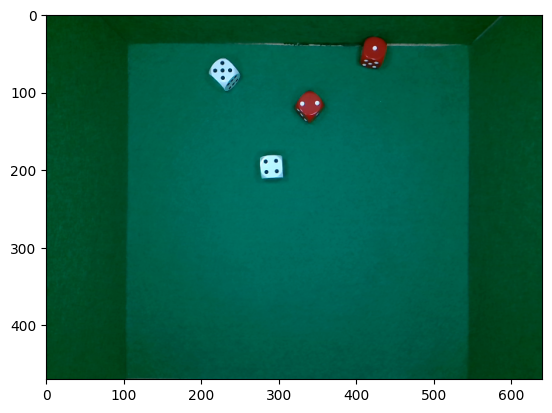

In [3]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np


path="/home/bule/projects/Dice/workspace/data/new_camera/still"
path2 = "/home/bule/projects/Dice/workspace/data/new_camera/empty"
images = []

for filename in os.listdir(path):
    img = cv2.imread(os.path.join(path, filename))
    if img is not None:
        img=img[:470,:,:]
        images.append(img)
        
for filename in os.listdir(path2):
    img = cv2.imread(os.path.join(path2, filename))
    if img is not None:
        img=img[:470,:,:]
        images.append(img)
             
        
        
for img in images[:1]:
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
import random
def remove_range(hsv_img,low,high):
    '''
    removes a certain range of values on an image and retruns rgb image
    img:hsv image
    low:lower bound e.g. [0,0,0]
    high:higher bound e.g. [255,255,255]
    '''
    bg_mask = cv2.inRange(hsv_img, low, high)
    dices_mask = cv2.bitwise_not(bg_mask)
    img=cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
    return cv2.bitwise_and(img, img, mask=dices_mask)


def get_cropped(orig_gray,img):
    '''
    returns cropped images of the dices
    img:rgb image
    orig_gray:gray image orignal to crop from 
    '''
    gray_img=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(gray_img, connectivity=8)
    output_image = np.zeros_like(gray_img)
    for i in range(1, num_labels):  # Start from 1 to ignore the background component
        if stats[i, cv2.CC_STAT_AREA] >= 50:
            output_image[labels == i] = 255  # Keep this connected component
    binary_mask = np.uint8(output_image > 0)
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cropped = []
    hull_mask = np.zeros_like(binary_mask)
    # Loop over each contour
    for contour in contours:
        hull = cv2.convexHull(contour)
        cv2.drawContours(hull_mask, [hull], -1, (255), thickness=cv2.FILLED)
        x, y, w, h = cv2.boundingRect(hull)
        orig_gray_i=orig_gray.copy()
        orig_gray_i[hull_mask==0]=0
        cropped_image = orig_gray_i[y:y+h, x:x+w]
        cropped.append(cropped_image)
    return cropped , hull_mask


def get_white_red(img):
    '''
    img: opencv bgr array 
    
    returns: list of cropped red and white dice images in grayscale
    '''
    # Original imag to grayscale and hsv
    orig_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # remove background -> white and red, only take the red ones
    rgb_nogreen=   remove_range(hsv_image,np.array([40, 0, 0]),np.array([90, 255, 255])) #rbg
    rgb_red = remove_range(cv2.cvtColor(rgb_nogreen, cv2.COLOR_RGB2HSV), np.array([30, 0, 0]), np.array([160, 255, 255]))
    
    # get cropped images for red  and the mask of the red die
    cropped_img_red , hull_mask_red =get_cropped(orig_gray,rgb_red)

    # remove red dice from the image
    rgb_nored = rgb_nogreen.copy()  
    rgb_nored[hull_mask_red == 255] = 0

    cropped_img_white, _ = get_cropped(orig_gray,rgb_nored)

    return cropped_img_red,cropped_img_white


def model_dummy(img):
    '''
    dummy model that returns the number of red and white dices
    mimics:  model.predict(img)
    '''
    return random.randint(1, 6)


def rerun_criterion(img_list):
    '''
    img_list: list of opencv i channel images
    returns: bool , True if criterion met else False
    '''
    criterion=True
    for img in img_list:
            if  ((img.shape[0] / img.shape[1]) > 1.4) or ((img.shape[1] / img.shape[0]) >  1.4):
                criterion = False
    return criterion


def main_dice(frame):
    '''
    img: opencv bgr array 
    returns: number of red and white dices, if criterion met bool
    '''
    cropped_img_red,cropped_img_white = get_white_red(frame)
    
    # check criterion
    if not rerun_criterion(cropped_img_red) or not rerun_criterion(cropped_img_white):
        return _ , False    
    
    resdict={"red_dice":[],"white_dice":[]}
    
    for img in cropped_img_red:
        resdict["red_dice"].append(model_dummy(img))
    for img in cropped_img_white:
        resdict["white_dice"].append(model_dummy(img))  
        
    return resdict, True



In [ ]:
for img in images[:]:
    plt.figure(figsize=(2, 2))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    resdict, run_criterion =main_dice(img)
    if not run_criterion:
        print("Oops something went wrong , try trhowing the dice again")
        continue
    else:
        print(resdict)

In [ ]:
for img in images[:]:
    
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    
    edges = cv2.Canny(img, 100, 200)
    plt.imshow(edges, cmap='gray')
    plt.show()
    
    cropped_img_red,cropped_img_white=get_white_red(img)
    
    for i in cropped_img_red:
        
        plt.imshow(i,cmap='gray')
        plt.show()
        
    for i in cropped_img_white:
        plt.imshow(i,cmap='gray')
        plt.show()